# 1 — Setup and Installation

This cell installs all required dependencies and registers the Atari environments (ALE) for Gymnasium.  
Run this only once (the first time you open the notebook or on a new machine).

It installs:
- **Gymnasium + Atari environments**
- **ALE-Py (Arcade Learning Environment)**
- **AutoROM** to automatically download the Atari ROMs  
- **PyTorch**, **NumPy**, and **Matplotlib**

In [2]:
# ===============================================================
#  Environment Setup - Install required libraries and register ALE
# ===============================================================

#!pip install torch torchvision matplotlib numpy tqdm opencv-python
#!pip install "gymnasium[atari,accept-rom-license]"
#!pip install ale-py
#!pip install autorom
#!AutoROM --accept-license

# 2 — Imports and Global Configuration

This cell imports all the main libraries used throughout the notebook.  
It also defines the **global configuration** (device setup, random seeds, etc.) for reproducibility and performance.

**Main libraries:**
- `gymnasium` → environment management  
- `torch` → neural networks and PPO implementation  
- `cv2` → image preprocessing (resize, grayscale)  
- `numpy` → numerical operations  
- `tqdm` → progress bars  
- `matplotlib` → training visualization


In [293]:
# ===============================================================
#  Imports and Global Configuration
# ===============================================================

import os
import cv2
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from tqdm import trange
from collections import deque

In [295]:
# ---- Device configuration ----
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

___

In [298]:
# ---- Device configuration (CPU or GPU via MPS on Mac) ----

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(" Using Apple Metal Performance Shaders (MPS) GPU")
else:
    device = torch.device("cpu")
    print(" MPS not available, using CPU")


 Using Apple Metal Performance Shaders (MPS) GPU


___

In [301]:
# ---- Random seed for reproducibility ----
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [303]:
# ---- Silence warnings for cleaner output ----
os.environ["PYTHONWARNINGS"] = "ignore"

#  3 — Atari Environment Preprocessing

In this section, we define a custom Gymnasium **wrapper** called `AtariPreprocessing`  
to standardize the input observations for the neural network.

**What it does:**
- Converts RGB frames to **grayscale**
- Resizes frames to **84×84**
- Normalizes pixel values to `[0, 1]`
- Stacks the last **4 frames** to capture motion information

This ensures that the neural network receives a consistent and simplified state representation.

In [307]:
# ===============================================================
# 🎮 Atari Environment Preprocessing Wrapper
# ===============================================================


# -- Register ALE namespace (required after notebook restarts) --
gym.envs.registration.register_envs(ale_py)
print(" ALE namespace registered successfully!")


class AtariPreprocessing(gym.Wrapper):
    """
    Custom preprocessing for Atari environments like Breakout.

    This wrapper:
    - Converts RGB frames to grayscale
    - Resizes frames to 84x84
    - Normalizes pixel values (0–1)
    - Stacks the last N frames (default: 4)
    """

    def __init__(self, env, frame_size=(84, 84), frame_stack=4):
        super().__init__(env)
        self.frame_size = frame_size
        self.frame_stack = frame_stack
        self.frames = deque(maxlen=frame_stack)

        # Define new observation space
        obs_shape = (frame_stack, *frame_size)
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=obs_shape, dtype=np.float32
        )

    def preprocess(self, obs):
        """Convert RGB → Grayscale → Resize → Normalize."""
        obs_gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        obs_resized = cv2.resize(obs_gray, self.frame_size, interpolation=cv2.INTER_AREA)
        obs_normalized = obs_resized / 255.0
        return obs_normalized

    def reset(self, **kwargs):
        """Reset environment and fill frame stack with first observation."""
        obs, info = self.env.reset(**kwargs)
        processed = self.preprocess(obs)
        for _ in range(self.frame_stack):
            self.frames.append(processed)
        return np.stack(self.frames, axis=0), info

    def step(self, action):
        """Process each frame and update the stack."""
        obs, reward, terminated, truncated, info = self.env.step(action)
        processed = self.preprocess(obs)
        self.frames.append(processed)
        return np.stack(self.frames, axis=0), reward, terminated, truncated, info


 ALE namespace registered successfully!


In [309]:
# ===============================================================
#  Quick Test: Validate Wrapper Functionality
# ===============================================================

env = AtariPreprocessing(gym.make("ALE/Breakout-v5"))
obs, info = env.reset(seed=42)

print(f" Observation shape: {obs.shape}")
print(f" Action space: {env.action_space}")

 Observation shape: (4, 84, 84)
 Action space: Discrete(4)


#  4 — Actor-Critic Neural Network (CNN)

The PPO algorithm uses a shared convolutional network that acts as both:
- **Actor (Policy network):** outputs a probability distribution over actions  
- **Critic (Value network):** estimates the expected future reward from the current state  

This shared architecture improves sample efficiency and ensures that both heads  
learn from the same visual features extracted from the environment.


In [313]:
# ===============================================================
#  Actor-Critic CNN Model for PPO
# ===============================================================

class ActorCriticCNN(nn.Module):
    """
    Shared CNN architecture for Actor and Critic networks in PPO.

    Input:  (batch_size, 4, 84, 84)
    Output: 
        - logits (policy distribution) → shape [batch_size, n_actions]
        - value  (state value estimate) → shape [batch_size, 1]
    """

    def __init__(self, input_shape=(4, 84, 84), n_actions=4):
        super(ActorCriticCNN, self).__init__()

        # --- Convolutional feature extractor ---
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # Compute output size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            n_flatten = self.conv(dummy).view(1, -1).shape[1]

        # --- Fully connected layers ---
        self.fc = nn.Linear(n_flatten, 512)
        self.actor = nn.Linear(512, n_actions)
        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        """Forward pass returning both policy logits and state value."""
        if x.max() > 1:  # normalize if input not pre-normalized
            x = x / 255.0
        features = self.conv(x)
        features = features.view(features.size(0), -1)
        hidden = F.relu(self.fc(features))

        logits = self.actor(hidden)  # Policy head
        value = self.critic(hidden)  # Value head
        return logits, value

In [315]:
# ===============================================================
#  Quick Test: Verify Network Output Dimensions
# ===============================================================

model = ActorCriticCNN()
dummy_input = torch.zeros((1, 4, 84, 84))
logits, value = model(dummy_input)

print("Logits shape :", logits.shape)  # Expected [1, 4]
print(" Value shape  :", value.shape)   # Expected [1, 1]

Logits shape : torch.Size([1, 4])
 Value shape  : torch.Size([1, 1])


#  5 — Rollout Buffer (Trajectory Memory)


The PPO algorithm doesn’t update the network after every single step.  
Instead, it collects data from several steps (or episodes) into a **rollout buffer**,  
then performs batched updates to improve stability.

The buffer stores:
- `states`: preprocessed observations  
- `actions`: actions taken by the policy  
- `log_probs`: log probabilities of those actions  
- `rewards`: rewards obtained after each action  
- `dones`: episode termination flags  
- `values`: estimated state values from the critic

In [319]:
# ===============================================================
#  Rollout Buffer for PPO
# ===============================================================

class RolloutBuffer:
    """
    A simple buffer that stores trajectories for PPO training.
    Each rollout is later used to compute advantages and returns.
    """

    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def store(self, state, action, log_prob, reward, done, value):
        """Stores one transition from the environment."""
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def clear(self):
        """Resets all stored trajectories."""
        self.__init__()

In [321]:

# ===============================================================
#  Quick Test: Validate Buffer Functionality
# ===============================================================

buffer = RolloutBuffer()
buffer.store(np.zeros((4, 84, 84)), 1, -0.5, 1.0, False, 0.25)

print(" Buffer test passed!")
print("States stored:", len(buffer.states))
print("Actions stored:", len(buffer.actions))


 Buffer test passed!
States stored: 1
Actions stored: 1


# 6 — Mémoire (RolloutBuffer)

This class implements the **Proximal Policy Optimization (PPO)** algorithm.

**Responsibilities:**
1. **Action selection** → sample an action using the Actor (policy network).  
2. **GAE computation** → estimate advantages to reduce variance and bias.  
3. **Policy update** → update Actor & Critic using clipped objective and entropy regularization.

**Main Components:**
- `select_action()` → chooses an action from the current policy.  
- `compute_gae()` → calculates advantages and discounted returns.  
- `update()` → performs multiple optimization epochs with mini-batches.


In [325]:
# ===============================================================
#  PPO Agent Implementation
# ===============================================================

class PPOAgent:
    """
    Core PPO Agent combining Actor-Critic and Rollout Buffer.
    """

    def __init__(self, env, gamma=0.99, lam=0.95, lr=2.5e-4, clip_eps=0.1, epochs=4, batch_size=64, device=device):
        self.env = env
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        # Initialize model and optimizer
        self.model = ActorCriticCNN().to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
       

        # Rollout buffer for storing transitions
        self.buffer = RolloutBuffer()

    # -----------------------------------------------------------
    #  Action selection
    # -----------------------------------------------------------
    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        logits, value = self.model(state_tensor)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action).item(), value.item()

    # -----------------------------------------------------------
    #  Compute GAE (Generalized Advantage Estimation)
    # -----------------------------------------------------------
    def compute_gae(self, next_value):
        rewards = np.array(self.buffer.rewards)
        values = np.array(self.buffer.values + [next_value])
        dones = np.array(self.buffer.dones)

        advantages = np.zeros_like(rewards)
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            advantages[t] = gae
        returns = advantages + values[:-1]
        return advantages, returns

    # -----------------------------------------------------------
    #  PPO update step
    # -----------------------------------------------------------
    def update(self, next_value):
        advantages, returns = self.compute_gae(next_value)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        states = torch.FloatTensor(np.array(self.buffer.states)).to(self.device)
        actions = torch.LongTensor(self.buffer.actions).to(self.device)
        old_log_probs = torch.FloatTensor(self.buffer.log_probs).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)

        dataset_size = len(states)
        for _ in range(self.epochs):
            indices = np.arange(dataset_size)
            np.random.shuffle(indices)
            for start in range(0, dataset_size, self.batch_size):
                end = start + self.batch_size
                batch_idx = indices[start:end]

                logits, values = self.model(states[batch_idx])
                probs = torch.softmax(logits, dim=-1)
                dist = Categorical(probs)
                log_probs = dist.log_prob(actions[batch_idx])
                entropy = dist.entropy().mean()

                ratio = torch.exp(log_probs - old_log_probs[batch_idx])
                surr1 = ratio * advantages[batch_idx]
                surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages[batch_idx]

                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = F.mse_loss(values.squeeze(), returns[batch_idx])
                #loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy
                loss = actor_loss + 0.5 * critic_loss - self.entropy_coef * entropy


                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                self.optimizer.step()


        self.buffer.clear()


# 7 — PPO Training Loop

This class implements the **Proximal Policy Optimization (PPO)** algorithm.  
It combines the Actor-Critic model with the Rollout Buffer.

### Responsibilities:
1. **Action Selection** → choose an action based on the policy (actor).  
2. **GAE Computation** → calculate advantages to reduce variance.  
3. **PPO Update** → optimize the policy with clipping and entropy regularization.

**Main methods:**
- `select_action()`  
- `compute_gae()`  
- `update()`


In [329]:
# ===============================================================
#  PPO Agent Implementation
# ===============================================================

class PPOAgent:
    """
    Core PPO Agent combining Actor-Critic and Rollout Buffer.
    Handles action selection, advantage computation, and policy updates.
    """

    def __init__(self, env, gamma=0.99, lam=0.95, lr=2.5e-4, clip_eps=0.1, epochs=4, batch_size=64, device=device):
        self.env = env
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        # Initialize model and optimizer
        self.model = ActorCriticCNN().to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)


        # Rollout buffer for storing transitions
        self.buffer = RolloutBuffer()

    # -----------------------------------------------------------
    #  Action selection
    # -----------------------------------------------------------
    def select_action(self, state):
        """
        Selects an action from the current policy given a state.
        Returns:
            - action (int)
            - log probability (float)
            - value estimate (float)
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        logits, value = self.model(state_tensor)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action).item(), value.item()

    # -----------------------------------------------------------
    #  Compute Generalized Advantage Estimation (GAE)
    # -----------------------------------------------------------
    def compute_gae(self, next_value):
        """
        Computes advantages and returns using Generalized Advantage Estimation (GAE).
        """
        rewards = np.array(self.buffer.rewards)
        values = np.array(self.buffer.values + [next_value])
        dones = np.array(self.buffer.dones)

        advantages = np.zeros_like(rewards)
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            advantages[t] = gae
        returns = advantages + values[:-1]
        return advantages, returns

    # -----------------------------------------------------------
    #  PPO Update Step
    # -----------------------------------------------------------
    def update(self, next_value):
        """
        Performs multiple PPO update epochs using the collected rollout data.
        """
        advantages, returns = self.compute_gae(next_value)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        states = torch.FloatTensor(np.array(self.buffer.states)).to(self.device)
        actions = torch.LongTensor(self.buffer.actions).to(self.device)
        old_log_probs = torch.FloatTensor(self.buffer.log_probs).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)

        dataset_size = len(states)
        for _ in range(self.epochs):
            indices = np.arange(dataset_size)
            np.random.shuffle(indices)
            for start in range(0, dataset_size, self.batch_size):
                end = start + self.batch_size
                batch_idx = indices[start:end]

                logits, values = self.model(states[batch_idx])
                probs = torch.softmax(logits, dim=-1)
                dist = Categorical(probs)

                log_probs = dist.log_prob(actions[batch_idx])
                entropy = dist.entropy().mean()

                ratio = torch.exp(log_probs - old_log_probs[batch_idx])
                surr1 = ratio * advantages[batch_idx]
                surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages[batch_idx]

                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = F.mse_loss(values.squeeze(), returns[batch_idx])
                loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                self.optimizer.step()

        self.buffer.clear()


#  8 — Agent PPO 


This function runs the main PPO training cycle.  
It lets the agent interact with the environment, store transitions in the rollout buffer,  
and periodically update both the policy (actor) and value (critic) networks.

**Key features:**
- `tqdm` progress bar for live monitoring  
- Optional rendering (`render=True`)  
- Tracks average rewards over time for convergence analysis

In [333]:
# ===============================================================
#  PPO Training Loop
# ===============================================================

def train_ppo(agent, total_timesteps=200_000, update_interval=2048, render=False):
    """
    Main PPO training loop.
    - Interacts with the environment.
    - Collects trajectories in the buffer.
    - Updates policy and value networks periodically.
    """
    env = agent.env
    obs, info = env.reset(seed=SEED)

    total_rewards = []
    episode_reward = 0
    timesteps = 0

    progress = trange(total_timesteps, desc="Training", ncols=100)
    while timesteps < total_timesteps:
        for _ in range(update_interval):
            if render:
                env.render()

            # ---- Action selection ----
            action, log_prob, value = agent.select_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            # ---- Store transition ----
            agent.buffer.store(obs, action, log_prob, reward, terminated or truncated, value)
            episode_reward += reward
            timesteps += 1
            obs = next_obs

            # ---- End of episode ----
            if terminated or truncated:
                total_rewards.append(episode_reward)
                episode_reward = 0
                obs, info = env.reset()

        # ---- Compute last value and update PPO ----
        _, _, next_value = agent.select_action(obs)
        agent.update(next_value)

        # ---- Logging ----
        if len(total_rewards) > 0:
            avg_reward = np.mean(total_rewards[-10:])
            progress.set_description(f" Avg Reward: {avg_reward:.2f}")
        progress.update(update_interval)

    env.close()
    return total_rewards

#  9 — Training Reward Visualization

After training, it’s essential to visualize how the total reward evolves over time.  
This helps verify that the PPO agent is actually learning and not diverging.

**This plot shows:**
- Raw episode rewards (noisy but detailed)
- Moving average of rewards (smoothed trend of learning)

In [337]:
# ===============================================================
#  Training Reward Visualization
# ===============================================================

def plot_rewards(rewards, window=20, save_path="ppo_breakout_rewards.png"):
    """
    Plots raw and moving average rewards from PPO training.
    Args:
        rewards (list): list of total rewards per episode
        window (int): smoothing window for moving average
        save_path (str): optional path to save the plot
    """
    plt.figure(figsize=(10, 5))
    plt.style.use("seaborn-v0_8")

    # --- Raw rewards ---
    plt.plot(rewards, color="skyblue", alpha=0.4, label="Episode Reward")

    # --- Moving average ---
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window) / window, mode="valid")
        plt.plot(moving_avg, color="orange", linewidth=2, label=f"Moving Average ({window})")

    plt.title("PPO Training Progress on Breakout")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

    print(f" Plot saved as '{save_path}'")


# 10 — Testing the Trained PPO Agent

Now that the model is trained, let’s evaluate how well it performs in the environment.

This section:
- Recreates the environment with `render_mode="human"`  
- Loads the trained model (if saved)  
- Lets the agent play several episodes  
- Displays the total reward per episode


In [341]:
# ===============================================================
#  PPO Agent Evaluation (Render Mode)
# ===============================================================

def test_agent(agent, episodes=5, model_path=None):
    """
    Test the trained PPO agent visually in Breakout.
    Args:
        agent: trained PPOAgent instance
        episodes (int): number of test episodes
        model_path (str): optional path to load a saved model
    """
    # Load model if path provided
    if model_path:
        agent.model.load_state_dict(torch.load(model_path, map_location=agent.device))
        agent.model.eval()
        print(f" Model loaded from: {model_path}")

    # Create a new environment with visual rendering
    test_env = AtariPreprocessing(gym.make("ALE/Breakout-v5", render_mode="human"))

    for ep in range(episodes):
        obs, info = test_env.reset(seed=SEED)
        done = False
        total_reward = 0

        while not done:
            action, _, _ = agent.select_action(obs)
            obs, reward, terminated, truncated, info = test_env.step(action)
            total_reward += reward
            done = terminated or truncated

        print(f" Episode {ep + 1} → Total Reward: {total_reward}")

    test_env.close()
    print(" Testing completed.")


# MAIN Run the PPO Agent Training and Evaluation

Now that all components are defined, we can:
1. Initialize the environment and agent.  
2. Train the PPO agent for a number of timesteps.  
3. Visualize the reward curve.  
4. Test the trained agent in `render_mode="human"`.

In [349]:
# ===============================================================
#  Run PPO Training and Evaluation
# ===============================================================

#  Initialize environment and PPO agent
env = AtariPreprocessing(gym.make("ALE/Breakout-v5"))
ppo_agent = PPOAgent(env, device=device)
print(" PPO agent and environment initialized successfully!")

 PPO agent and environment initialized successfully!


In [351]:
env = AtariPreprocessing(gym.make("ALE/Breakout-v5"))
ppo_agent = PPOAgent(env, device=device)

In [353]:
print("\n Starting PPO training...")
rewards = train_ppo(ppo_agent, total_timesteps=50_000, update_interval=1024)


 Starting PPO training...









Training:   0%|                                                           | 0/50000 [00:00<?, ?it/s]






 Avg Reward: 1.00:   0%|                                                  | 0/50000 [00:06<?, ?it/s]






 Avg Reward: 1.00:   2%|▊                                     | 1024/50000 [00:06<05:33, 146.67it/s]






 Avg Reward: 1.20:   2%|▊                                     | 1024/50000 [00:13<05:33, 146.67it/s]






 Avg Reward: 1.20:   4%|█▌                                    | 2048/50000 [00:13<05:24, 147.68it/s]






 Avg Reward: 2.00:   4%|█▌                                    | 2048/50000 [00:20<05:24, 147.68it/s]






 Avg Reward: 2.00:   6%|██▎                                   | 3072/50000 [00:20<05:21, 145.95it/s]






 Avg Reward: 1.70:   6%|██▎                                   | 3072/50000 [00:27<05:21, 145.95it/s]






 Avg Reward: 1.70:   8%|███                                   | 4096/50000 [00:27<05:13, 146.25it/s]






 Avg Reward: 1.20:   8%|███   


 Plotting reward curve...


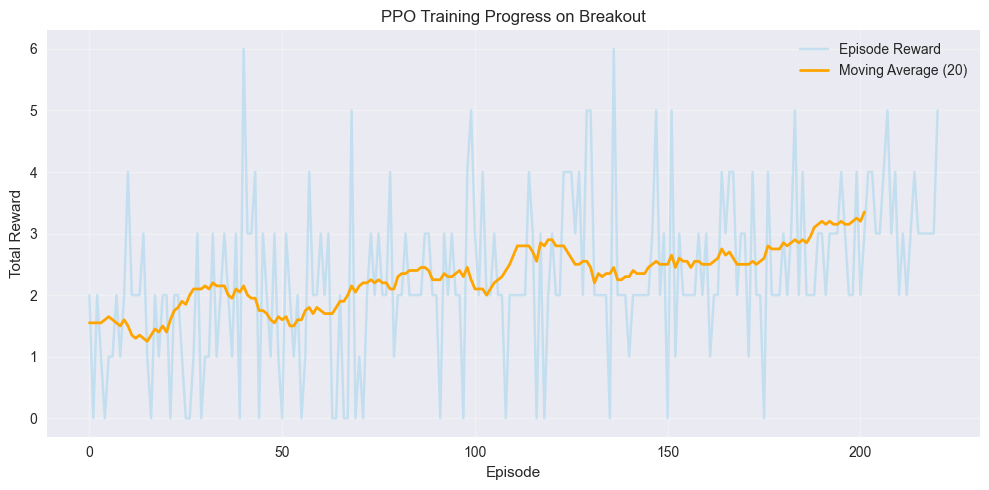

 Plot saved as 'ppo_breakout_rewards.png'


In [354]:
# 3️ Visualize training results
print("\n Plotting reward curve...")
plot_rewards(rewards)

In [355]:
#  Test the trained agent visually
print("\n Testing trained agent (rendering)...")
test_agent(ppo_agent, episodes=3)


 Testing trained agent (rendering)...
 Episode 1 → Total Reward: 2.0
 Episode 2 → Total Reward: 0.0
 Episode 3 → Total Reward: 2.0
 Testing completed.


# Entrainement Continue

 Starting incremental PPO training...

 Cycle 1/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 2.44:   0%|                                                 | 0/250000 [00:15<?, ?it/s]






 Avg Reward: 2.44:   1%|▎                                    | 2048/250000 [00:15<31:10, 132.53it/s]






 Avg Reward: 2.30:   1%|▎                                    | 2048/250000 [00:29<31:10, 132.53it/s]






 Avg Reward: 2.30:   2%|▌                                    | 4096/250000 [00:29<29:25, 139.27it/s]






 Avg Reward: 2.30:   2%|▌                                    | 4096/250000 [00:41<29:25, 139.27it/s]






 Avg Reward: 2.90:   2%|▌                                    | 4096/250000 [00:44<29:25, 139.27it/s]






 Avg Reward: 2.90:   2%|▉                                    | 6144/250000 [00:44<28:56, 140.45it/s]






 Avg Reward: 3.30:   2%|▉                                    | 6144/250000 [00:58<28:56, 140.45it/s]






 Avg Reward: 3.30:   3%|█▏    


 Evaluating agent performance...
 Avg test reward after cycle 1: 8.00
 New best model saved! (Avg reward: 8.00)


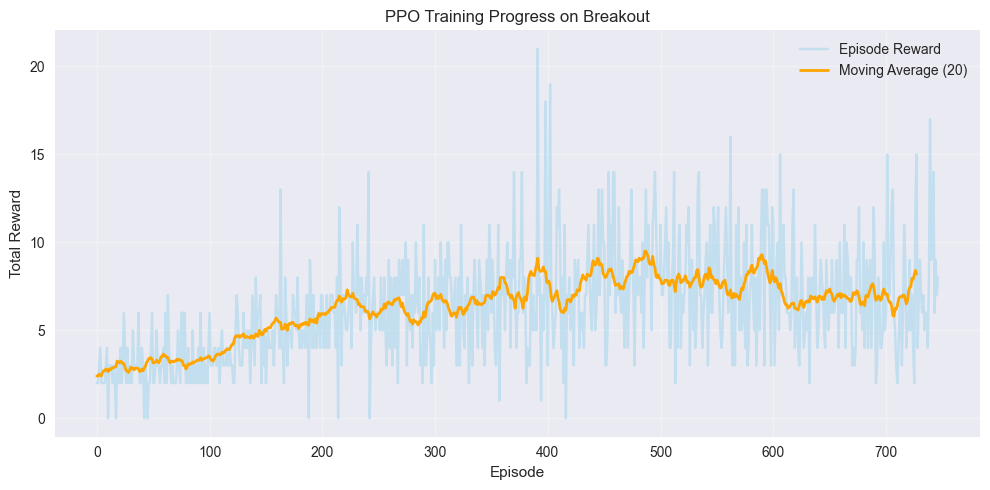

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 2/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 6.60:   0%|                                                 | 0/250000 [00:14<?, ?it/s]






 Avg Reward: 6.60:   1%|▎                                    | 2048/250000 [00:14<29:39, 139.34it/s]






 Avg Reward: 6.60:   1%|▎                                    | 2048/250000 [00:25<29:39, 139.34it/s]






 Avg Reward: 7.20:   1%|▎                                    | 2048/250000 [00:29<29:39, 139.34it/s]






 Avg Reward: 7.20:   2%|▌                                    | 4096/250000 [00:29<29:07, 140.71it/s]






 Avg Reward: 7.70:   2%|▌                                    | 4096/250000 [00:42<29:07, 140.71it/s]






 Avg Reward: 7.70:   2%|▉                                    | 6144/250000 [00:42<28:04, 144.76it/s]






 Avg Reward: 7.70:   2%|▉                                    | 6144/250000 [00:55<28:04, 144.76it/s]






 Avg Reward: 7.90:   2%|▉     


 Evaluating agent performance...
 Avg test reward after cycle 2: 8.33
 New best model saved! (Avg reward: 8.33)


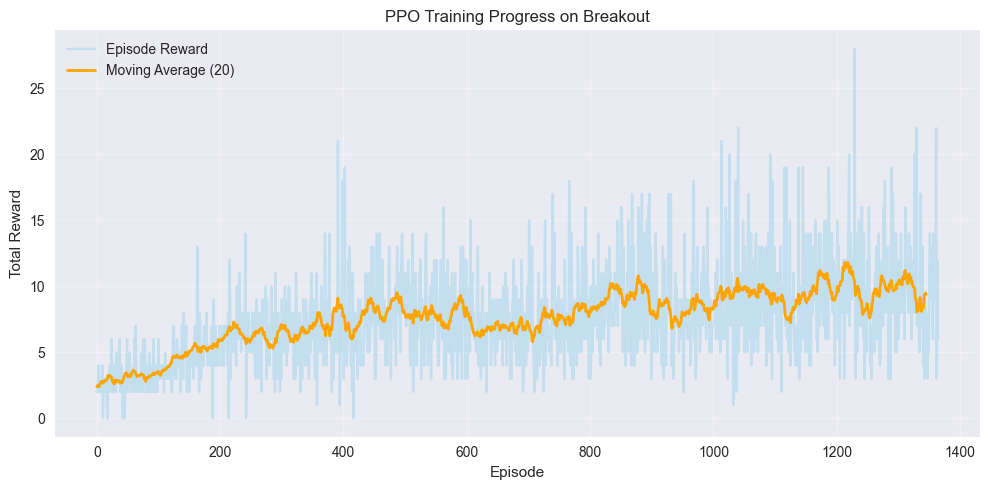

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 3/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 7.00:   0%|                                                 | 0/250000 [00:10<?, ?it/s]






 Avg Reward: 7.00:   1%|▎                                    | 2048/250000 [00:10<20:29, 201.61it/s]






 Avg Reward: 7.90:   1%|▎                                    | 2048/250000 [00:20<20:29, 201.61it/s]






 Avg Reward: 7.90:   2%|▌                                    | 4096/250000 [00:20<20:56, 195.68it/s]






 Avg Reward: 8.20:   2%|▌                                    | 4096/250000 [00:30<20:56, 195.68it/s]






 Avg Reward: 8.20:   2%|▉                                    | 6144/250000 [00:30<20:20, 199.85it/s]






 Avg Reward: 8.50:   2%|▉                                    | 6144/250000 [00:40<20:20, 199.85it/s]






 Avg Reward: 8.50:   3%|█▏                                   | 8192/250000 [00:40<19:47, 203.60it/s]






 Avg Reward: 7.40:   3%|█▏    


 Evaluating agent performance...
 Avg test reward after cycle 3: 9.33
 New best model saved! (Avg reward: 9.33)


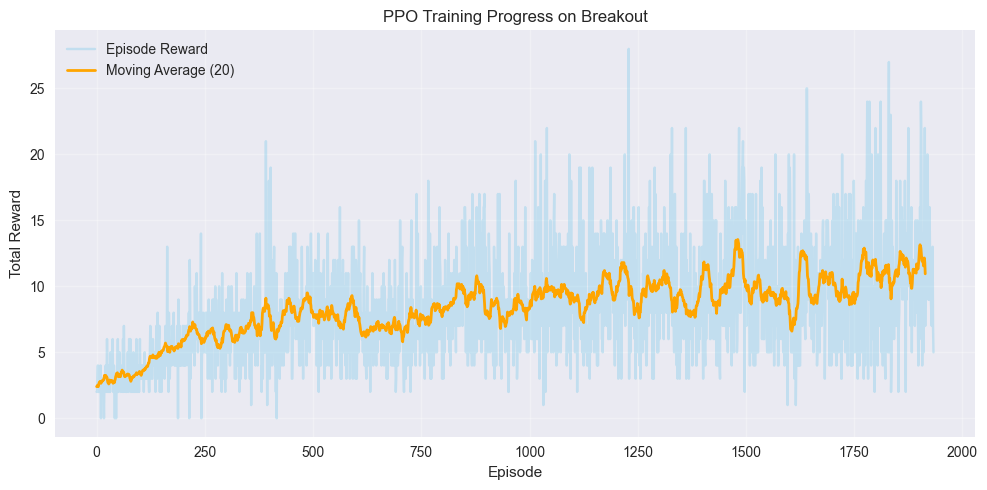

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 4/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 9.75:   0%|                                                 | 0/250000 [00:09<?, ?it/s]






 Avg Reward: 9.75:   1%|▎                                    | 2048/250000 [00:09<19:55, 207.39it/s]






 Avg Reward: 10.11:   1%|▎                                   | 2048/250000 [00:20<19:55, 207.39it/s]






 Avg Reward: 10.11:   2%|▌                                   | 4096/250000 [00:20<20:03, 204.31it/s]






 Avg Reward: 10.00:   2%|▌                                   | 4096/250000 [00:29<20:03, 204.31it/s]






 Avg Reward: 10.00:   2%|▉                                   | 6144/250000 [00:29<19:47, 205.36it/s]






 Avg Reward: 12.30:   2%|▉                                   | 6144/250000 [00:39<19:47, 205.36it/s]






 Avg Reward: 12.30:   3%|█▏                                  | 8192/250000 [00:39<19:27, 207.11it/s]






 Avg Reward: 12.70:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 4: 10.33
 New best model saved! (Avg reward: 10.33)


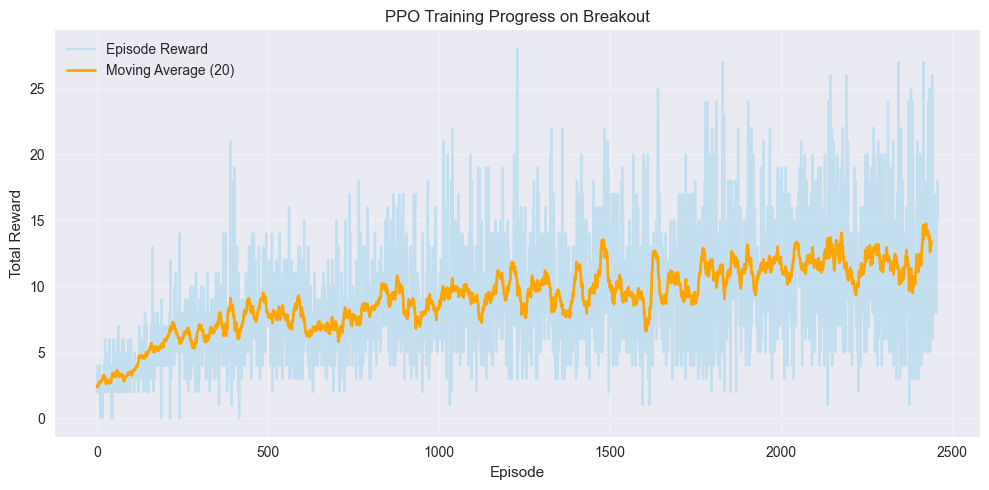

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 5/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 13.67:   0%|                                                | 0/250000 [00:15<?, ?it/s]






 Avg Reward: 13.67:   1%|▎                                   | 2048/250000 [00:15<30:30, 135.47it/s]






 Avg Reward: 13.67:   1%|▎                                   | 2048/250000 [00:26<30:30, 135.47it/s]






 Avg Reward: 11.33:   1%|▎                                   | 2048/250000 [00:29<30:30, 135.47it/s]






 Avg Reward: 11.33:   2%|▌                                   | 4096/250000 [00:29<29:21, 139.56it/s]






 Avg Reward: 10.20:   2%|▌                                   | 4096/250000 [00:43<29:21, 139.56it/s]






 Avg Reward: 10.20:   2%|▉                                   | 6144/250000 [00:43<28:56, 140.44it/s]






 Avg Reward: 10.20:   2%|▉                                   | 6144/250000 [00:56<28:56, 140.44it/s]






 Avg Reward: 11.80:   2%|▉    


 Evaluating agent performance...
 Avg test reward after cycle 5: 12.33
 New best model saved! (Avg reward: 12.33)


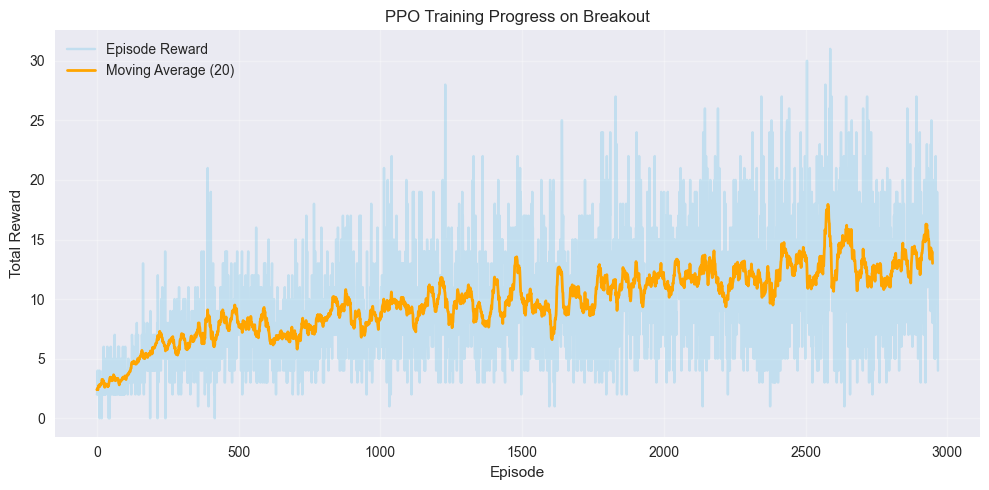

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 6/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 18.67:   0%|                                                | 0/250000 [00:14<?, ?it/s]






 Avg Reward: 18.67:   1%|▎                                   | 2048/250000 [00:14<28:15, 146.26it/s]






 Avg Reward: 18.67:   1%|▎                                   | 2048/250000 [00:25<28:15, 146.26it/s]






 Avg Reward: 13.86:   1%|▎                                   | 2048/250000 [00:28<28:15, 146.26it/s]






 Avg Reward: 13.86:   2%|▌                                   | 4096/250000 [00:28<28:04, 145.94it/s]






 Avg Reward: 13.20:   2%|▌                                   | 4096/250000 [00:42<28:04, 145.94it/s]






 Avg Reward: 13.20:   2%|▉                                   | 6144/250000 [00:42<27:55, 145.54it/s]






 Avg Reward: 13.20:   2%|▉                                   | 6144/250000 [00:55<27:55, 145.54it/s]






 Avg Reward: 11.10:   2%|▉    


 Evaluating agent performance...
 Avg test reward after cycle 6: 13.00
 New best model saved! (Avg reward: 13.00)


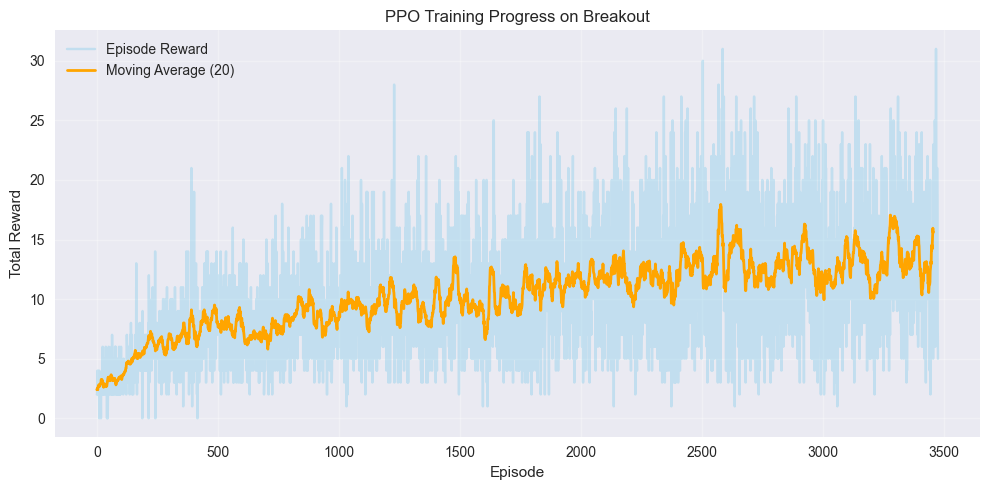

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 7/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 10.75:   0%|                                                | 0/250000 [00:10<?, ?it/s]






 Avg Reward: 10.75:   1%|▎                                   | 2048/250000 [00:10<22:01, 187.67it/s]






 Avg Reward: 13.57:   1%|▎                                   | 2048/250000 [00:22<22:01, 187.67it/s]






 Avg Reward: 13.57:   2%|▌                                   | 4096/250000 [00:22<22:03, 185.78it/s]






 Avg Reward: 13.40:   2%|▌                                   | 4096/250000 [00:32<22:03, 185.78it/s]






 Avg Reward: 13.40:   2%|▉                                   | 6144/250000 [00:32<21:28, 189.32it/s]






 Avg Reward: 13.10:   2%|▉                                   | 6144/250000 [00:43<21:28, 189.32it/s]






 Avg Reward: 13.10:   3%|█▏                                  | 8192/250000 [00:43<21:14, 189.69it/s]






 Avg Reward: 12.30:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 7: 14.67
 New best model saved! (Avg reward: 14.67)


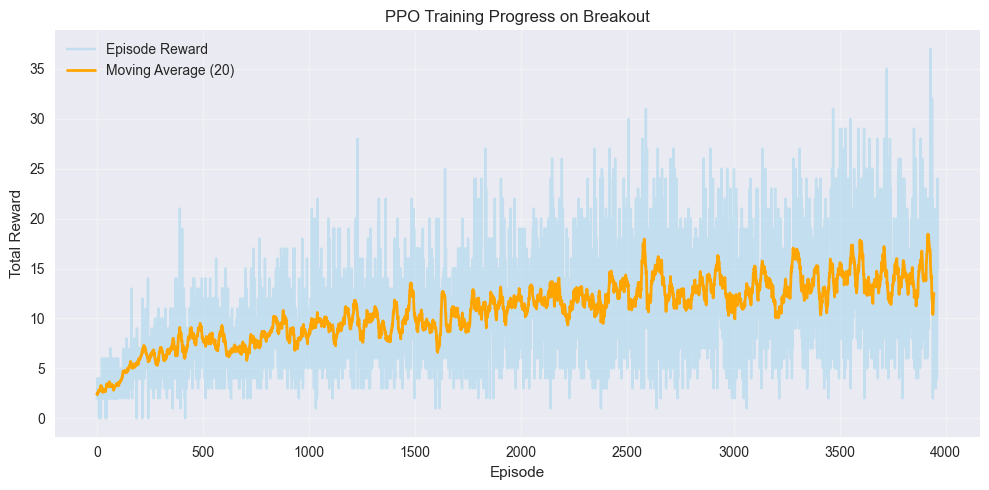

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 8/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 14.50:   0%|                                                | 0/250000 [00:11<?, ?it/s]






 Avg Reward: 14.50:   1%|▎                                   | 2048/250000 [00:11<22:49, 181.10it/s]






 Avg Reward: 14.62:   1%|▎                                   | 2048/250000 [00:24<22:49, 181.10it/s]






 Avg Reward: 14.62:   2%|▌                                   | 4096/250000 [00:24<24:18, 168.59it/s]






 Avg Reward: 14.50:   2%|▌                                   | 4096/250000 [00:34<24:18, 168.59it/s]






 Avg Reward: 14.50:   2%|▉                                   | 6144/250000 [00:34<22:34, 180.02it/s]






 Avg Reward: 12.60:   2%|▉                                   | 6144/250000 [00:45<22:34, 180.02it/s]






 Avg Reward: 12.60:   3%|█▏                                  | 8192/250000 [00:45<21:59, 183.23it/s]






 Avg Reward: 14.70:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 8: 14.00
 Current model underperforms — reloading best model...


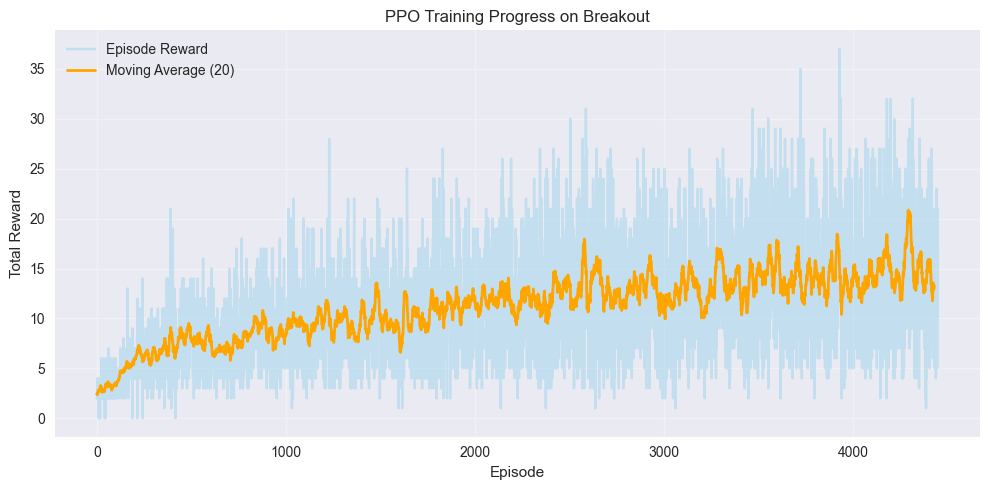

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 9/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 12.75:   0%|                                                | 0/250000 [00:10<?, ?it/s]






 Avg Reward: 12.75:   1%|▎                                   | 2048/250000 [00:10<21:38, 191.03it/s]






 Avg Reward: 12.62:   1%|▎                                   | 2048/250000 [00:21<21:38, 191.03it/s]






 Avg Reward: 12.62:   2%|▌                                   | 4096/250000 [00:21<21:33, 190.13it/s]






 Avg Reward: 12.00:   2%|▌                                   | 4096/250000 [00:32<21:33, 190.13it/s]






 Avg Reward: 12.00:   2%|▉                                   | 6144/250000 [00:32<21:25, 189.67it/s]






 Avg Reward: 11.60:   2%|▉                                   | 6144/250000 [00:42<21:25, 189.67it/s]






 Avg Reward: 11.60:   3%|█▏                                  | 8192/250000 [00:42<21:02, 191.60it/s]






 Avg Reward: 13.70:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 9: 16.33
 New best model saved! (Avg reward: 16.33)


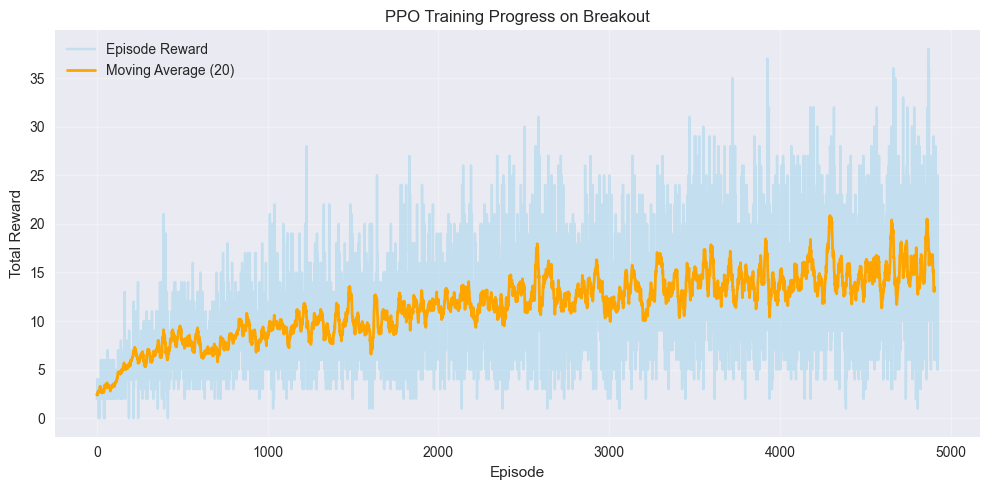

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 10/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 19.33:   0%|                                                | 0/250000 [00:10<?, ?it/s]






 Avg Reward: 19.33:   1%|▎                                   | 2048/250000 [00:10<21:57, 188.24it/s]






 Avg Reward: 17.57:   1%|▎                                   | 2048/250000 [00:21<21:57, 188.24it/s]






 Avg Reward: 17.57:   2%|▌                                   | 4096/250000 [00:21<21:13, 193.04it/s]






 Avg Reward: 17.20:   2%|▌                                   | 4096/250000 [00:31<21:13, 193.04it/s]






 Avg Reward: 17.20:   2%|▉                                   | 6144/250000 [00:31<20:58, 193.72it/s]






 Avg Reward: 14.90:   2%|▉                                   | 6144/250000 [00:42<20:58, 193.72it/s]






 Avg Reward: 14.90:   3%|█▏                                  | 8192/250000 [00:42<20:47, 193.86it/s]






 Avg Reward: 16.70:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 10: 18.00
 New best model saved! (Avg reward: 18.00)


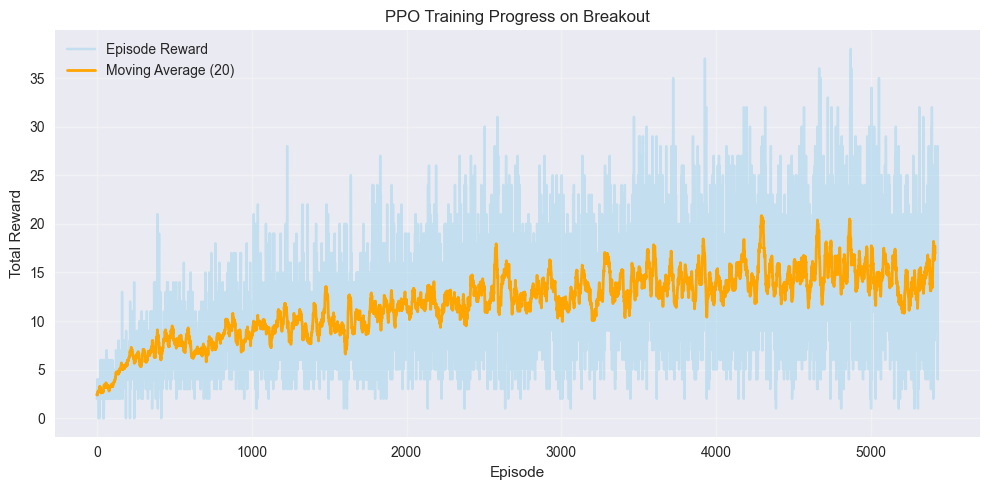

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 11/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 18.67:   0%|                                                | 0/250000 [00:10<?, ?it/s]






 Avg Reward: 18.67:   1%|▎                                   | 2048/250000 [00:10<20:48, 198.64it/s]






 Avg Reward: 19.57:   1%|▎                                   | 2048/250000 [00:20<20:48, 198.64it/s]






 Avg Reward: 19.57:   2%|▌                                   | 4096/250000 [00:20<20:35, 199.09it/s]






 Avg Reward: 18.60:   2%|▌                                   | 4096/250000 [00:30<20:35, 199.09it/s]






 Avg Reward: 18.60:   2%|▉                                   | 6144/250000 [00:30<20:20, 199.85it/s]






 Avg Reward: 15.70:   2%|▉                                   | 6144/250000 [00:40<20:20, 199.85it/s]






 Avg Reward: 15.70:   3%|█▏                                  | 8192/250000 [00:40<20:07, 200.26it/s]






 Avg Reward: 13.30:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 11: 20.33
 New best model saved! (Avg reward: 20.33)


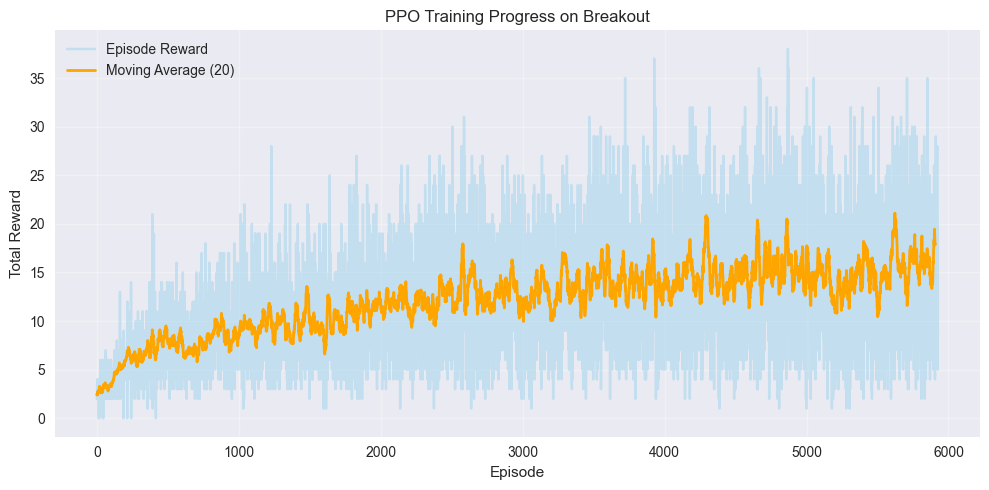

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 12/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 14.75:   0%|                                                | 0/250000 [00:10<?, ?it/s]






 Avg Reward: 14.75:   1%|▎                                   | 2048/250000 [00:10<21:17, 194.02it/s]






 Avg Reward: 14.75:   1%|▎                                   | 2048/250000 [00:21<21:17, 194.02it/s]






 Avg Reward: 14.75:   2%|▌                                   | 4096/250000 [00:21<21:16, 192.70it/s]






 Avg Reward: 13.40:   2%|▌                                   | 4096/250000 [00:31<21:16, 192.70it/s]






 Avg Reward: 13.40:   2%|▉                                   | 6144/250000 [00:31<21:05, 192.69it/s]






 Avg Reward: 13.40:   2%|▉                                   | 6144/250000 [00:42<21:05, 192.69it/s]






 Avg Reward: 13.90:   2%|▉                                   | 6144/250000 [00:42<21:05, 192.69it/s]






 Avg Reward: 13.90:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 12: 14.00
 Current model underperforms — reloading best model...


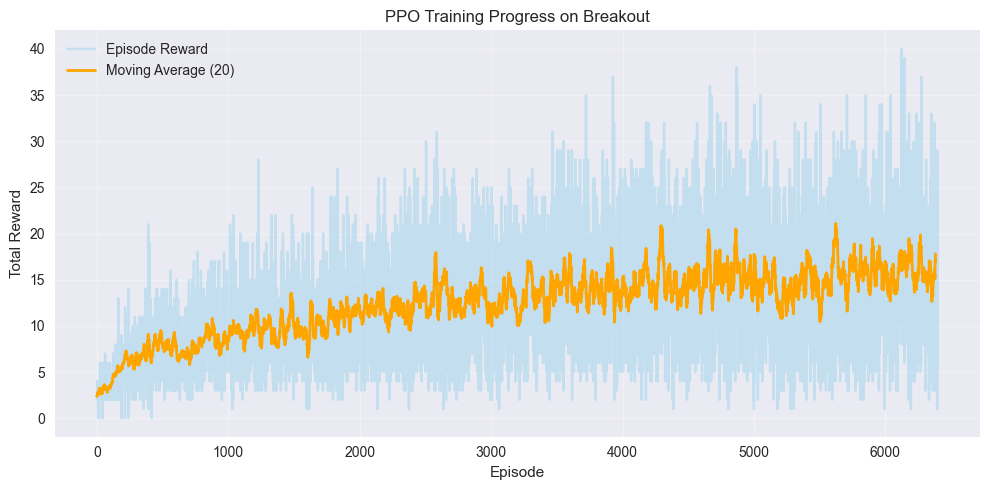

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 13/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 11.50:   0%|                                                | 0/250000 [00:10<?, ?it/s]






 Avg Reward: 11.50:   1%|▎                                   | 2048/250000 [00:10<21:50, 189.26it/s]






 Avg Reward: 12.88:   1%|▎                                   | 2048/250000 [00:21<21:50, 189.26it/s]






 Avg Reward: 12.88:   2%|▌                                   | 4096/250000 [00:21<21:10, 193.50it/s]






 Avg Reward: 13.80:   2%|▌                                   | 4096/250000 [00:31<21:10, 193.50it/s]






 Avg Reward: 13.80:   2%|▉                                   | 6144/250000 [00:31<20:41, 196.46it/s]






 Avg Reward: 13.40:   2%|▉                                   | 6144/250000 [00:42<20:41, 196.46it/s]






 Avg Reward: 13.40:   3%|█▏                                  | 8192/250000 [00:42<20:40, 194.92it/s]






 Avg Reward: 14.00:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 13: 7.67
 Current model underperforms — reloading best model...


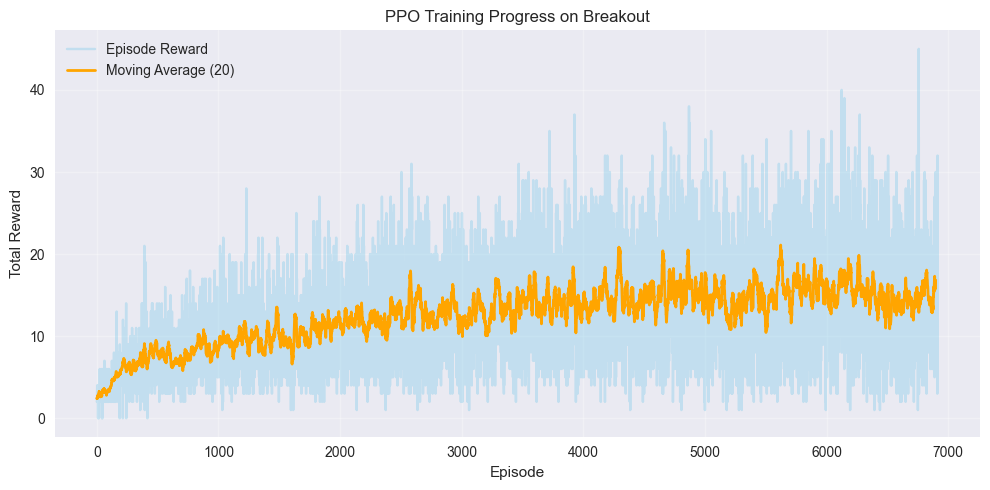

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 14/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 11.00:   0%|                                                | 0/250000 [00:14<?, ?it/s]






 Avg Reward: 11.00:   1%|▎                                   | 2048/250000 [00:14<28:50, 143.29it/s]






 Avg Reward: 11.00:   1%|▎                                   | 2048/250000 [00:27<28:50, 143.29it/s]






 Avg Reward: 10.80:   1%|▎                                   | 2048/250000 [00:28<28:50, 143.29it/s]






 Avg Reward: 10.80:   2%|▌                                   | 4096/250000 [00:28<28:19, 144.71it/s]






 Avg Reward: 10.30:   2%|▌                                   | 4096/250000 [00:45<28:19, 144.71it/s]






 Avg Reward: 10.30:   2%|▉                                   | 6144/250000 [00:45<31:01, 130.99it/s]






 Avg Reward: 10.30:   2%|▉                                   | 6144/250000 [00:57<31:01, 130.99it/s]






 Avg Reward: 15.70:   2%|▉    


 Evaluating agent performance...
 Avg test reward after cycle 14: 15.33
 Current model underperforms — reloading best model...


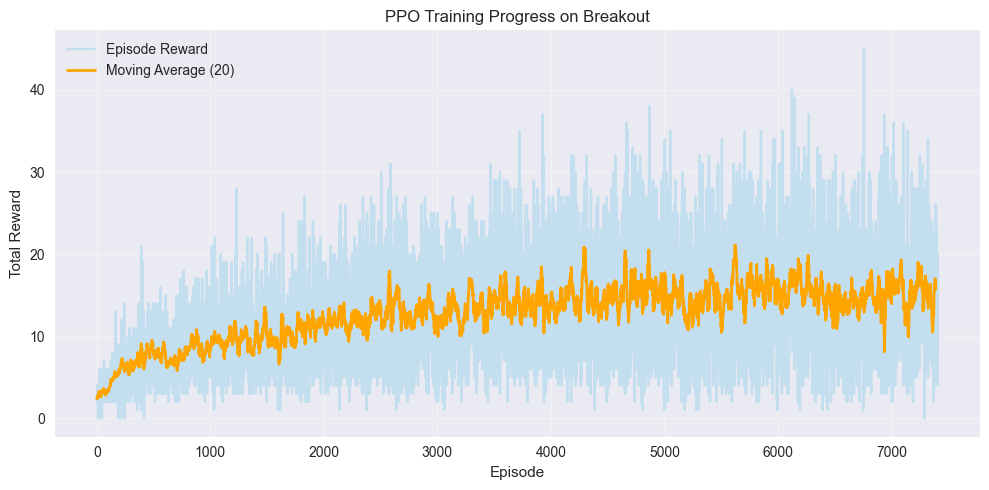

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 15/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 13.75:   0%|                                                | 0/250000 [00:15<?, ?it/s]






 Avg Reward: 13.75:   1%|▎                                   | 2048/250000 [00:15<31:36, 130.74it/s]






 Avg Reward: 16.00:   1%|▎                                   | 2048/250000 [00:30<31:36, 130.74it/s]






 Avg Reward: 16.00:   2%|▌                                   | 4096/250000 [00:30<30:33, 134.09it/s]






 Avg Reward: 16.00:   2%|▌                                   | 4096/250000 [00:43<30:33, 134.09it/s]






 Avg Reward: 13.80:   2%|▌                                   | 4096/250000 [00:44<30:33, 134.09it/s]






 Avg Reward: 13.80:   2%|▉                                   | 6144/250000 [00:44<29:03, 139.86it/s]






 Avg Reward: 12.30:   2%|▉                                   | 6144/250000 [00:58<29:03, 139.86it/s]






 Avg Reward: 12.30:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 15: 10.00
 Current model underperforms — reloading best model...


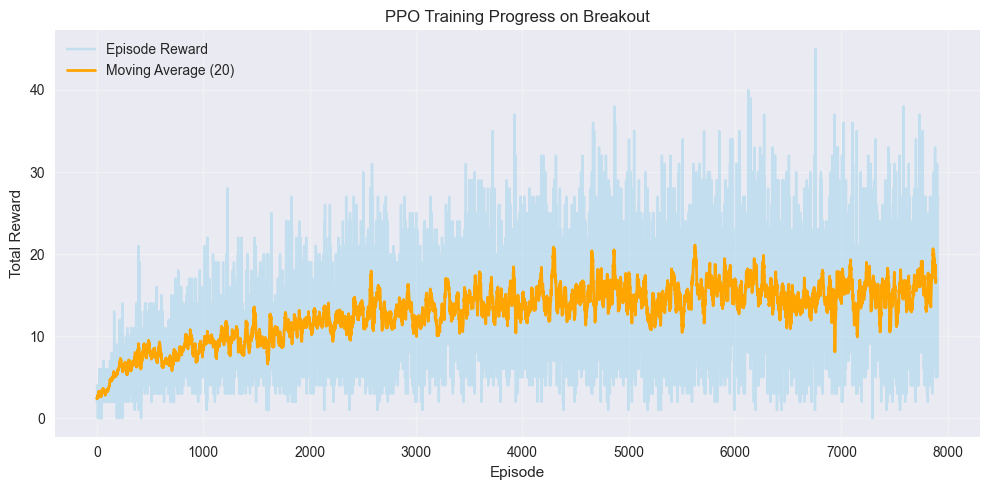

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 16/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 17.33:   0%|                                                | 0/250000 [00:13<?, ?it/s]






 Avg Reward: 17.33:   1%|▎                                   | 2048/250000 [00:13<27:47, 148.67it/s]






 Avg Reward: 17.33:   1%|▎                                   | 2048/250000 [00:23<27:47, 148.67it/s]






 Avg Reward: 15.88:   1%|▎                                   | 2048/250000 [00:27<27:47, 148.67it/s]






 Avg Reward: 15.88:   2%|▌                                   | 4096/250000 [00:27<27:38, 148.27it/s]






 Avg Reward: 16.10:   2%|▌                                   | 4096/250000 [00:41<27:38, 148.27it/s]






 Avg Reward: 16.10:   2%|▉                                   | 6144/250000 [00:41<27:08, 149.73it/s]






 Avg Reward: 16.10:   2%|▉                                   | 6144/250000 [00:53<27:08, 149.73it/s]






 Avg Reward: 14.60:   2%|▉    


 Evaluating agent performance...
 Avg test reward after cycle 16: 16.00
 Current model underperforms — reloading best model...


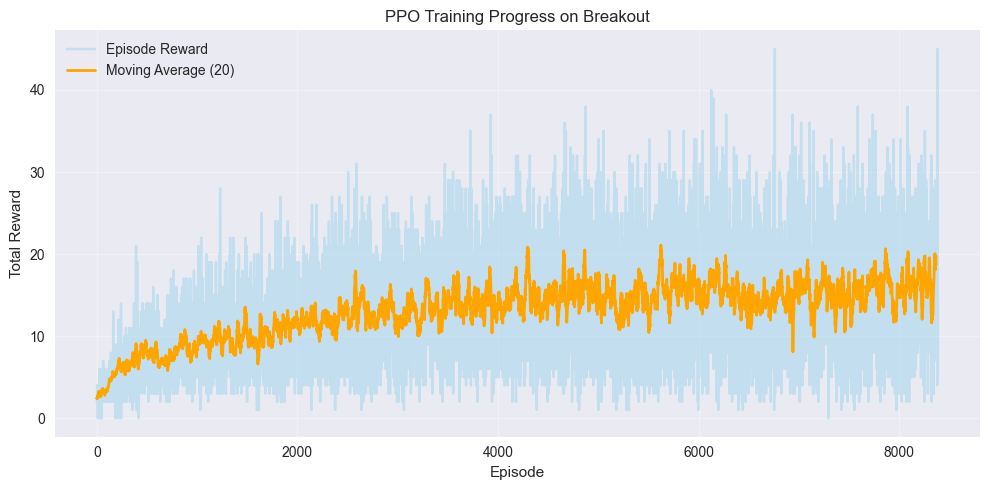

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 17/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 18.25:   0%|                                                | 0/250000 [00:13<?, ?it/s]






 Avg Reward: 18.25:   1%|▎                                   | 2048/250000 [00:13<28:11, 146.58it/s]






 Avg Reward: 16.25:   1%|▎                                   | 2048/250000 [00:28<28:11, 146.58it/s]






 Avg Reward: 16.25:   2%|▌                                   | 4096/250000 [00:28<28:06, 145.83it/s]






 Avg Reward: 16.25:   2%|▌                                   | 4096/250000 [00:40<28:06, 145.83it/s]






 Avg Reward: 14.70:   2%|▌                                   | 4096/250000 [00:42<28:06, 145.83it/s]






 Avg Reward: 14.70:   2%|▉                                   | 6144/250000 [00:42<28:18, 143.60it/s]






 Avg Reward: 13.60:   2%|▉                                   | 6144/250000 [00:57<28:18, 143.60it/s]






 Avg Reward: 13.60:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 17: 15.67
 Current model underperforms — reloading best model...


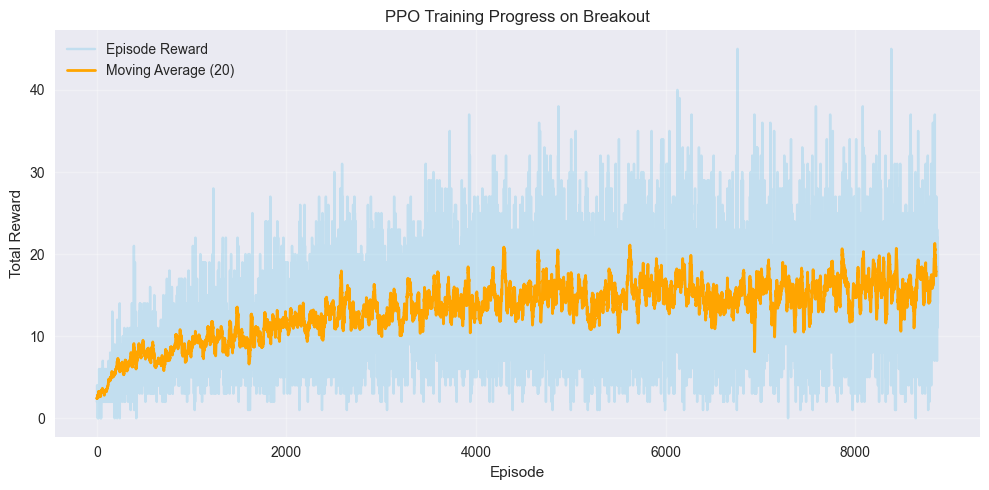

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 18/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 14.25:   0%|                                                | 0/250000 [00:15<?, ?it/s]






 Avg Reward: 14.25:   1%|▎                                   | 2048/250000 [00:15<31:29, 131.23it/s]






 Avg Reward: 14.25:   1%|▎                                   | 2048/250000 [00:25<31:29, 131.23it/s]






 Avg Reward: 13.62:   1%|▎                                   | 2048/250000 [00:29<31:29, 131.23it/s]






 Avg Reward: 13.62:   2%|▌                                   | 4096/250000 [00:29<29:45, 137.69it/s]






 Avg Reward: 14.30:   2%|▌                                   | 4096/250000 [00:44<29:45, 137.69it/s]






 Avg Reward: 14.30:   2%|▉                                   | 6144/250000 [00:44<29:08, 139.48it/s]






 Avg Reward: 14.30:   2%|▉                                   | 6144/250000 [00:55<29:08, 139.48it/s]






 Avg Reward: 20.60:   2%|▉    


 Evaluating agent performance...
 Avg test reward after cycle 18: 13.33
 Current model underperforms — reloading best model...


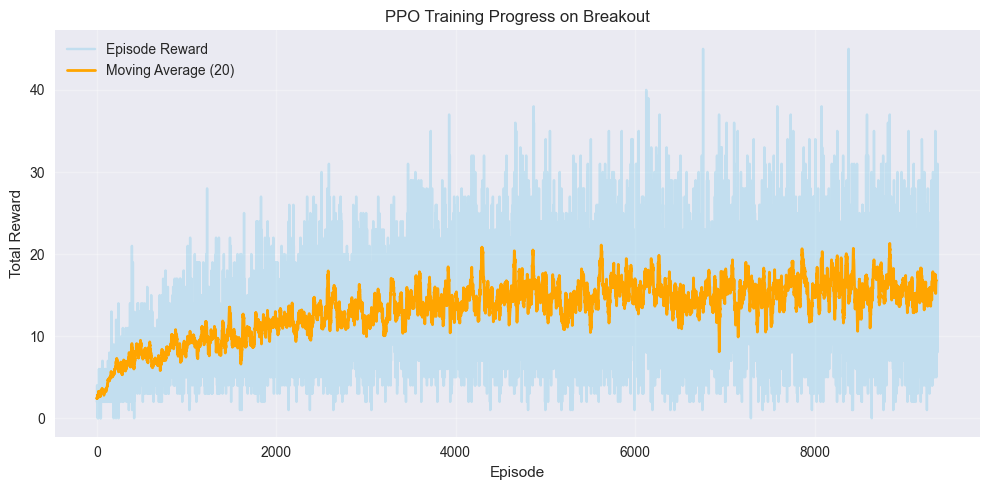

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 19/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 21.00:   0%|                                                | 0/250000 [00:14<?, ?it/s]






 Avg Reward: 21.00:   1%|▎                                   | 2048/250000 [00:14<28:31, 144.90it/s]






 Avg Reward: 21.83:   1%|▎                                   | 2048/250000 [00:28<28:31, 144.90it/s]






 Avg Reward: 21.83:   2%|▌                                   | 4096/250000 [00:28<28:45, 142.49it/s]






 Avg Reward: 21.83:   2%|▌                                   | 4096/250000 [00:40<28:45, 142.49it/s]






 Avg Reward: 21.89:   2%|▌                                   | 4096/250000 [00:42<28:45, 142.49it/s]






 Avg Reward: 21.89:   2%|▉                                   | 6144/250000 [00:42<28:20, 143.44it/s]






 Avg Reward: 17.90:   2%|▉                                   | 6144/250000 [00:57<28:20, 143.44it/s]






 Avg Reward: 17.90:   3%|█▏   


 Evaluating agent performance...
 Avg test reward after cycle 19: 17.00
 Current model underperforms — reloading best model...


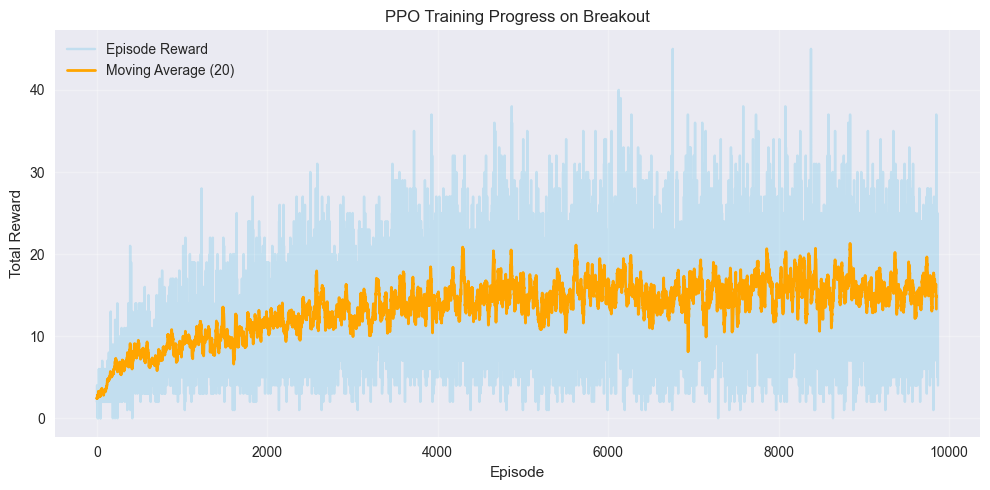

 Plot saved as 'ppo_breakout_rewards.png'

 Cycle 20/20 — Training for 250,000 steps









Training:   0%|                                                          | 0/250000 [00:00<?, ?it/s]






 Avg Reward: 20.00:   0%|                                                | 0/250000 [00:14<?, ?it/s]






 Avg Reward: 20.00:   1%|▎                                   | 2048/250000 [00:14<29:33, 139.77it/s]






 Avg Reward: 20.00:   1%|▎                                   | 2048/250000 [00:27<29:33, 139.77it/s]






 Avg Reward: 19.57:   1%|▎                                   | 2048/250000 [00:28<29:33, 139.77it/s]






 Avg Reward: 19.57:   2%|▌                                   | 4096/250000 [00:28<28:29, 143.85it/s]






 Avg Reward: 14.40:   2%|▌                                   | 4096/250000 [00:42<28:29, 143.85it/s]






 Avg Reward: 14.40:   2%|▉                                   | 6144/250000 [00:43<28:24, 143.09it/s]






 Avg Reward: 9.10:   2%|▉                                    | 6144/250000 [00:57<28:24, 143.09it/s]






 Avg Reward: 9.10:   3%|█▏    


 Evaluating agent performance...
 Avg test reward after cycle 20: 21.33
 New best model saved! (Avg reward: 21.33)


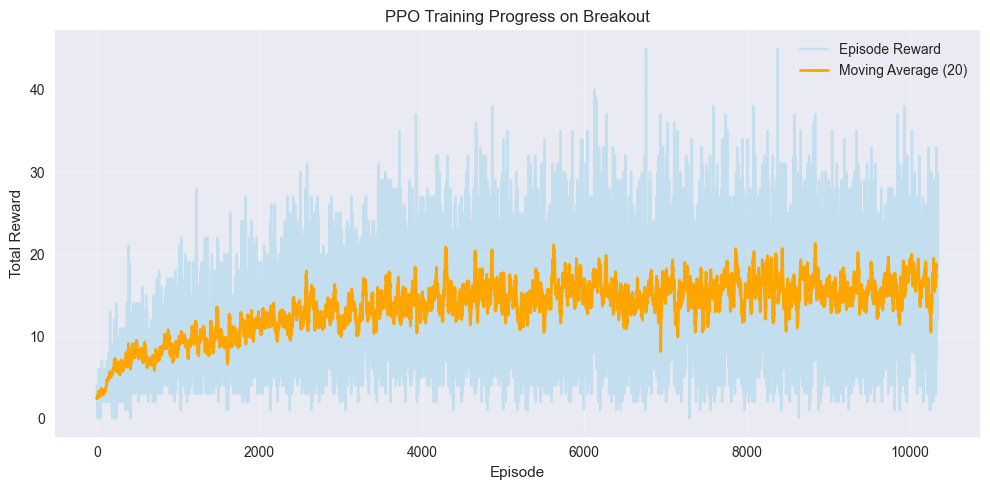

 Plot saved as 'ppo_breakout_rewards.png'

 Training complete!
 Best model average test reward: 21.33


In [357]:
# ===============================================================
#  Progressive PPO Training with Best Model Selection
# ===============================================================

# Parameters
total_cycles = 20      # number of training cycles (ex: 10 * 100k = 1M steps total)
steps_per_cycle = 250_000  # how many timesteps per training cycle
update_interval = 2048     # PPO update frequency
best_score = -float("inf") # start with worst possible score
best_model_path = "ppo_best_model.pth"
all_rewards = []           # track training progress

print(" Starting incremental PPO training...")

for cycle in range(1, total_cycles + 1):
    print(f"\n Cycle {cycle}/{total_cycles} — Training for {steps_per_cycle:,} steps")

    # ---- Train agent ----
    rewards = train_ppo(ppo_agent, total_timesteps=steps_per_cycle, update_interval=update_interval)
    all_rewards += rewards  # concatenate rewards from each cycle

    # ---- Evaluate agent performance ----
    print("\n Evaluating agent performance...")
    test_env = AtariPreprocessing(gym.make("ALE/Breakout-v5"))
    scores = []
    for ep in range(3):  # test for 3 episodes
        obs, info = test_env.reset(seed=SEED)
        done = False
        total_reward = 0
        while not done:
            action, _, _ = ppo_agent.select_action(obs)
            obs, reward, terminated, truncated, info = test_env.step(action)
            total_reward += reward
            done = terminated or truncated
        scores.append(total_reward)
    test_env.close()

    avg_score = np.mean(scores)
    print(f" Avg test reward after cycle {cycle}: {avg_score:.2f}")

    # ---- Compare to best model ----
    if avg_score > best_score:
        best_score = avg_score
        torch.save(ppo_agent.model.state_dict(), best_model_path)
        print(f" New best model saved! (Avg reward: {avg_score:.2f})")
    else:
        print(" Current model underperforms — reloading best model...")
        ppo_agent.model.load_state_dict(torch.load(best_model_path, map_location=device))

    # ---- Plot training progress ----
    plot_rewards(all_rewards)

print("\n Training complete!")
print(f" Best model average test reward: {best_score:.2f}")


In [545]:
# ===============================================================
# Test the trained PPO agent (visual simulation)
# ===============================================================

def simulate_agent(agent, episodes=10, model_path="ppo_best_model.pth"):
    """
    Watch the trained PPO agent play Breakout.
    """
    # Charger le meilleur modèle
    agent.model.load_state_dict(torch.load(model_path, map_location=device))
    agent.model.eval()
    print(f" Model loaded from {model_path}")

    # Créer un environnement avec rendu visuel
    env = AtariPreprocessing(gym.make("ALE/Breakout-v5", render_mode="human"))

    for ep in range(episodes):
        obs, info = env.reset(seed=42)
        done = False
        total_reward = 0

        while not done:
            action, _, _ = agent.select_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated

        print(f" Episode {ep + 1}: Total reward = {total_reward:.2f}")

    env.close()
    print(" Simulation finished!")

# Run the visual simulation
simulate_agent(ppo_agent, episodes=10)


 Model loaded from ppo_best_model.pth
 Episode 1: Total reward = 20.00
 Episode 2: Total reward = 18.00
 Episode 3: Total reward = 24.00
 Episode 4: Total reward = 16.00
 Episode 5: Total reward = 25.00
 Episode 6: Total reward = 24.00
 Episode 7: Total reward = 16.00
 Episode 8: Total reward = 17.00
 Episode 9: Total reward = 22.00
 Episode 10: Total reward = 12.00
 Simulation finished!


In [543]:
import imageio
from IPython.display import Video

env = AtariPreprocessing(gym.make("ALE/Breakout-v5", render_mode="rgb_array"))
frames = []

obs, info = env.reset(seed=42)
done = False
total_reward = 0

while not done:
    action, _, _ = ppo_agent.select_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())  # capture la frame
    total_reward += reward
    done = terminated or truncated

env.close()
print(f"🎯 Total reward: {total_reward}")

# Sauvegarde la vidéo et affiche-la
imageio.mimsave("ppo_breakout_play.mp4", frames, fps=30)
Video("ppo_breakout_play.mp4", embed=True)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


🎯 Total reward: 27.0


# ===============================================================
#  Adjust hyperparameters for continued training (no restart)
# ===============================================================

In [380]:
# Update PPOAgent parameters
ppo_agent.gamma = 0.99
ppo_agent.lam = 0.95
ppo_agent.clip_eps = 0.10
ppo_agent.epochs = 4
ppo_agent.batch_size = 256
ppo_agent.entropy_coef = 0.005   # reduced exploration for fine-tuning

# Update optimizer learning rate
for g in ppo_agent.optimizer.param_groups:
    g['lr'] = 1e-4   # lower LR for more stable fine-tuning

# Set longer update interval for better advantage estimation
update_interval = 8192

print(" Hyperparameters updated successfully.")
print(f"Learning rate: {g['lr']}, entropy_coef: {ppo_agent.entropy_coef}, clip_eps: {ppo_agent.clip_eps}")


 Hyperparameters updated successfully.
Learning rate: 0.0001, entropy_coef: 0.005, clip_eps: 0.1


In [381]:
ppo_agent.model.load_state_dict(torch.load("ppo_best_model.pth", map_location=device))
print(" Model reloaded successfully — ready for continued training.")

 Model reloaded successfully — ready for continued training.


In [386]:
total_cycles = 10
steps_per_cycle = 8_000_000  # tu peux mettre 500_000 si tu veux aller plus loin
rewards = train_ppo(ppo_agent, total_timesteps=steps_per_cycle, update_interval=update_interval)








Training:   0%|                                                          | 0/300000 [00:00<?, ?it/s]






 Avg Reward: 20.10:   0%|                                                | 0/300000 [00:49<?, ?it/s]






 Avg Reward: 20.10:   3%|▉                                   | 8192/300000 [00:49<29:37, 164.21it/s]






 Avg Reward: 20.10:   3%|▉                                   | 8192/300000 [01:04<29:37, 164.21it/s]






 Avg Reward: 22.10:   3%|▉                                   | 8192/300000 [01:38<29:37, 164.21it/s]






 Avg Reward: 22.10:   5%|█▉                                 | 16384/300000 [01:38<28:16, 167.22it/s]






 Avg Reward: 22.10:   5%|█▉                                 | 16384/300000 [01:54<28:16, 167.22it/s]






 Avg Reward: 18.00:   5%|█▉                                 | 16384/300000 [02:26<28:16, 167.22it/s]






 Avg Reward: 18.00:   8%|██▊                                | 24576/300000 [02:26<27:21, 167.83it/s]






 Avg Reward: 18.00:   8%|██▊  

In [529]:



env = AtariPreprocessing(gym.make("ALE/Breakout-v5", render_mode="rgb_array"))
frames = []

obs, info = env.reset(seed=42)
done = False
total_reward = 0

while not done:
    action, _, _ = ppo_agent.select_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())
    total_reward += reward
    done = terminated or truncated

env.close()
print(f"total : {total_reward:.2f}")

# Save and display video
imageio.mimsave("ppo_breakout_play_latest.mp4", frames, fps=25)
Video("ppo_breakout_play_latest.mp4", embed=True)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


total : 28.00
